# 3D-α-WGAN-GP

下記を元に作成

- Kwon, et al. (2019), "Generation of 3D Brain MRI Using Auto-Encoding Generative Adversarial Networks", MICCAI 2019.
  - [Paper](https://arxiv.org/abs/1908.02498)
  - [GitHub](https://github.com/cyclomon/3dbraingen)

In [ ]:
# Google Driveのマウント
# 学習済みモデルの保存等に必要なら実行

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# 執筆時点でのパッケージバージョン。必要なら実行

#!pip install matplotlib==3.2.2
#!pip install numpy==1.19.5
#!pip install nibabel==3.0.2
#!pip install scikit-image==0.16.2
#!pip install torch==1.7.0+cu101
#!pip install torchvision==0.8.1+cu101

## 学習

### データセットのダウンロード

In [ ]:
!wget http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
!mkdir ixi_dataset
!tar -xvf IXI-T1.tar -C ixi_dataset


--2021-02-04 15:19:28--  http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
Resolving biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)... 146.169.22.31
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar [following]
--2021-02-04 15:19:28--  https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4840816640 (4.5G) [application/x-tar]
Saving to: ‘IXI-T1.tar’

IXI-T1.tar          100%[===================>]   4.51G  22.5MB/s    in 3m 30s  

2021-02-04 15:22:59 (22.0 MB/s) - ‘IXI-T1.tar’ saved [4840816640/4840816640]

IXI002-Guys-0828-T1.nii.gz
IXI012-HH-1211-T1.nii.gz
IXI013-HH-1212-T1.nii.gz
IXI014-HH-1236-T1.nii.gz
IXI015-HH-1

### データセットクラスの定義

In [ ]:
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset

# 前処理後のボクセルの一辺の長さ
cube_len = 64


class IXIDataset(Dataset):
    """
    訓練データの読み込みと前処理を行うクラス

    Attributes
    ----------
    img_paths : list
        全訓練データへのパスのリスト
    transform : torchvision.transforms.transforms.Compose
        前処理まとめたクラスのインスタンス
    """
    def __init__(self, img_paths, transform=None):
        """
        初期化

        Parameters
        ----------
        img_paths : list
            全訓練データへのパスのリスト
        transform : torchvision.transforms.transforms.Compose
            前処理まとめたクラスのインスタンス
        """
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        """
        訓練データの数を返す
        """
        return len(self.img_paths)

    def __getitem__(self, idx):
        """
        データの読み込み・前処理を行う

        Parameters
        ----------
        idx : int or numpy.ndarray
            読み込むデータを特定する整数
        Returns
        -------
        img : torch.Tensor
            前処理された訓練データ
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_paths[idx]
        img = nib.load(img_name).get_fdata()

        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
from skimage.transform import resize


class Centering(object):
    """
    入力ボクセルを空のボクセルの中央に配置する処理を行う

    Attributes
    ----------
    max_len : int
        空のボクセルの一辺の長さ(=元データの一辺の長さ)
    """
    def __init__(self):
        """
        初期化
        """
        self.max_len = 256

    def __call__(self, img):
        """
        Parameters
        ----------
        img : numpy.ndarray
            入力ボクセル
        
        Returns
        -------
        img : numpy.ndarray
            中央に配置・リサイズされたボクセル
        """
        # ずらす量を計算
        min_len = img.shape[-1]
        offset = (self.max_len - min_len) // 2
        # 空のボクセルを作成
        pad = np.zeros((self.max_len, self.max_len, self.max_len))
        # 入力ボクセルを空のボクセルの中央に配置
        pad[:, :, offset:self.max_len - offset] = img
        # 目的の大きさにリサイズ
        img = resize(pad, (cube_len, cube_len, cube_len))
        return img


class Normalize(object):
    """
    ボクセルの値を正規化する処理を行う

    Attributes
    ----------
    minv : int
        正規化後の最小値
    maxv : int
        正規化後の最大値
    """
    def __init__(self, minv=-1, maxv=1):
        """
        初期化

        Parameters
        ----------
        minv : int default -1
            正規化後の最小値
        maxv : int default 1
            正規化後の最大値
        """
        self.minv = minv
        self.maxv = maxv

    def __call__(self, img):
        """
        Parameters
        ----------
        img : numpy.ndarray
            入力ボクセル

        Returns
        -------
        img : numpy.ndarray
            正規化されたボクセル
        """
        # 入力ボクセルの最大・最小値を取得
        mina = np.min(img)
        maxa = np.max(img)
        # 例外処理
        if mina == maxa:
            return img * self.minv        
        # 正規化
        norm = (img - mina) / (maxa - mina)
        img = (norm * (self.maxv - self.minv)) + self.minv
        return img


class ToTensor(object):
    """
    numpy.ndarrayをtorch.Tensorに変換する
    """
    def __call__(self, img):
        """
        Parameters
        ----------
        img : numpy.ndarray
            入力ボクセル

        Returns
        -------
        img : torch.Tensor
            torch.Tensorに変換されたボクセル
        """
        img = torch.from_numpy(img).float()
        img = torch.unsqueeze(img, 0)
        return img

In [ ]:
import glob
from torch.utils.data import DataLoader
from torchvision import transforms

workers = 4 # データ読み込みに使用するプロセス数
batch_size = 4 # バッチサイズ
img_paths = glob.glob("ixi_dataset/*.nii.gz") # すべてのデータのpathを取得

# 前処理用のクラスをまとめる
composed = transforms.Compose([Centering(), Normalize(), ToTensor()])
# データセットからデータをサンプルするdata_loaderを作成
dataset = IXIDataset(img_paths, transform=composed)
data_loader = DataLoader(dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=workers,
                         drop_last=True)


def inf_train_gen(data_loader):
    """
    データを無限にサンプルする

    Parameters
    ----------
    data_loader : torch.utils.data.DataLoader
        データをサンプルするDataLoaderクラスのインスタンス

    Yields
    -------
    data : torch.Tensor
        前処理済みのボクセルデータ
    """
    while True:
        for data in data_loader:
            yield data


In [ ]:
import torch.nn as nn


class Interpolate(nn.Module):
    """
    torch.Tensorのスケール変換を行う
    
    Attributes
    ----------
    interp : function
        スケール変換を行う関数
    scale : float
        スケール変換の倍率
    mode : str
        スケール変換手法
    """
    def __init__(self, scale, mode):
        """
        初期化

        Parameters
        ----------
        scale : float
            スケール変換の倍率
        mode : str
            スケール変換手法
            'nearest' | 'linear' | 'bilinear' | 'bicubic' | 'trilinear' | 'area'
        """
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale = scale
        self.mode = mode

    def forward(self, x):
        """
        スケール変換を行う

        Parameters
        ----------
        x : torch.Tensor
            入力データ

        Returns
        -------
        x : torch.Tensor
            スケール変換されたデータ
        """
        x = self.interp(x, scale_factor=self.scale, mode=self.mode)
        return x

### モデルの定義

In [ ]:
class Generator(nn.Module):
    """
    生成器(G)を定義するクラス
    
    Attributes
    ----------
    latent : int
        入力ノイズの次元数
    interpolate : Interpolate
        torch.nn.Moduleを継承したスケール変換クラスのインスタンス
    main : torch.nn.Sequential
        ノイズからボクセル生成を行うレイヤーを定義したオブジェクト
    """

    def __init__(self, latent=1000):
        """
        初期化

        Parameters
        ----------
        latent : int default 1000
            入力ノイズの次元数
        """
        super(Generator, self).__init__()
        ngf = 64
        self.latent = latent
        self.interpolate = Interpolate(scale=2, mode='nearest')
        self.main = nn.Sequential(
        # レイヤー 1
            nn.ConvTranspose3d(self.latent, ngf * 8, 4, 1, 0),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
        # レイヤー 2
            self.interpolate,
            nn.Conv3d(ngf * 8, ngf * 4, 3, 1, 1),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
        # レイヤー 3
            self.interpolate,
            nn.Conv3d(ngf * 4, ngf * 2, 3, 1, 1),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
        # レイヤー 4
            self.interpolate,
            nn.Conv3d(ngf * 2, ngf * 1, 3, 1, 1),
            nn.BatchNorm3d(ngf * 1),
            nn.ReLU(True),
        # レイヤー 5
            self.interpolate,
            nn.Conv3d(ngf * 1, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, input):
        """
        ノイズからボクセル生成を行う

        Parameters
        ----------
        input : torch.Tensor
            入力ノイズ

        Returns
        -------
        torch.Tensor
            生成されたボクセル
        """
        # ノイズを畳み込み可能な形状に変形
        input = input.view(-1, self.latent, 1, 1, 1)
        return self.main(input)

In [ ]:
class EDModel(nn.Module):
    """
    変換器(E)と識別器(D)を定義するクラス
    
    Attributes
    ----------
    main : torch.nn.Sequential
        生成されたボクセルを受け取り、指定サイズの
        Tensorに変換するレイヤーを定義したオブジェクト
    """

    def __init__(self, out_num=1):
        """
        初期化

        Parameters
        ----------
        out_num : int default 1
            モデルの出力次元数
        """
        super(EDModel, self).__init__()
        ndf = 64
        self.main = nn.Sequential(
        # レイヤー 1
            nn.Conv3d(1, ndf * 1, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        # レイヤー 2
            nn.Conv3d(ndf * 1, ndf * 2, 4, 2, 1),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        # レイヤー 3
            nn.Conv3d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        # レイヤー 4
            nn.Conv3d(ndf * 4, ndf * 8, 4, 2, 1),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        # レイヤー 5
            nn.Conv3d(ndf * 8, out_num, 4, 2, 0),
        )

    def forward(self, input):
        """
        ボクセルを指定サイズのTensorへと変換する

        Parameters
        ----------
        input : torch.Tensor
            入力ボクセル

        Returns
        -------
        torch.Tensor
            変換されたTensor
        """
        return self.main(input)

In [ ]:
class CodeDiscriminator(nn.Module):
    """
    コード識別器(CD)を定義するクラス
    
    Attributes
    ----------
    latent : int
        入力コードの次元数
    main : torch.nn.Sequential
        入力コードをスコアに変換するレイヤーを定義した
        オブジェクト
    """
    def __init__(self, latent=1000):
        """
        初期化

        Parameters
        ----------
        latent : int default 1000
            入力コードの次元数
        """
        super(CodeDiscriminator, self).__init__()
        ndf = 4096
        self.latent = latent_dim
        self.main = nn.Sequential(
        # レイヤー 1
            nn.Linear(self.latent, ndf),
            nn.BatchNorm1d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
        # レイヤー 2
            nn.Linear(ndf, ndf),
            nn.BatchNorm1d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
        # レイヤー 3
            nn.Linear(ndf, 1),
        )

    def forward(self, input):
        """
        入力コードのスコアを返す

        Parameters
        ----------
        input : torch.Tensor
            入力コード

        Returns
        -------
        torch.Tensor
            コードに対するスコア
        """
        # コードが全結合を通るように変形
        input = input.view(b_size, self.latent)
        return self.main(input)

In [ ]:
# 変換器の出力次元数
latent_dim = 1000

# 使用するデバイスを設定
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# モデルをインスタンス化
E = EDModel(out_num=latent_dim).to(device).train()
G = Generator().to(device).train()
D = EDModel(out_num=1).to(device).train()
CD = CodeDiscriminator().to(device).train()

### 損失関数・オプティマイザ

In [ ]:
 _eps = 1e-15


def gradient_penalty(model, x, x_fake, w=10):
    """
    gradient penaltyを計算する

    Parameters
    ----------
    model : EDModel or CodeDiscriminator
        gradient penaltyを適用したい識別器(D)またはコード識別器(CD)のインスタンス
    x : torch.Tensor
        訓練データ
    x_fake : torch.Tensor
        生成器による生成データ
    w : int
        gradient penaltyの重要度

    Returns
    -------
    penalty : float
        gradient penaltyの値
    """
    # xと同じ次元を作成
    alpha_size = tuple((len(x), *(1, ) * (x.dim() - 1)))
    alpha_t = torch.Tensor
    alpha = alpha_t(*alpha_size).to(device).uniform_()
    # ランダムな係数で補間する
    x_hat = (x.data * alpha + x_fake.data * (1 - alpha)).requires_grad_()

    def eps_norm(x):
        """
        L2ノルムを計算する

        Parameters
        ----------
        x : torch.Tensor
            入力データ

        Returns
        -------
        torch.Tensor
            入力のL2ノルム
        """
        x = x.view(len(x), -1)
        return (x * x + _eps).sum(-1).sqrt()

    def bi_penalty(x):
        """
        入力と1との二乗誤差を計算する

        Parameters
        ----------
        x : torch.Tensor
            入力データ

        Returns
        -------
        torch.Tensor
            計算された二乗誤差
        """
        return (x - 1)**2

    # x_hatに関するDの勾配を計算
    grad_x_hat = torch.autograd.grad(model(x_hat).sum(),
                                     x_hat,
                                     create_graph=True,
                                     only_inputs=True)[0]

    # 勾配のnormを1にするためのペナルティ項を計算
    penalty = w * bi_penalty(eps_norm(grad_x_hat)).mean()
    return penalty

In [ ]:
# 生成器/変換器の学習のための再構成誤差
loss_l1 = nn.L1Loss()

In [ ]:
import torch.optim as optim

# オプティマイザのハイパーパラメータ
lr = 0.0002
betas = (0.5, 0.999)

# モデルごとに異なるオプティマイザを作成
optimizer_E = optim.Adam(E.parameters(), lr=lr, betas=betas)
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=betas)
optimizer_CD = optim.Adam(CD.parameters(), lr=lr, betas=betas)

In [ ]:
def freeze_params(*args):
    """
    モデルの重みを勾配計算なしに設定する

    Parameters
    ----------
    *args : tuple
        Generator, EDModel, CodeDiscriminatorのインスタンスのタプル
    """
    for module in args:
        if module:
            for p in module.parameters():
                p.requires_grad = False


def unfreeze_params(*args):
    """
    モデルの重みを勾配計算ありに設定する

    Parameters
    ----------
    *args : tuple
        Generator, EDModel, CodeDiscriminatorのインスタンスのタプル
    """
    for module in args:
        if module:
            for p in module.parameters():
                p.requires_grad = True

### 学習ループ

In [ ]:
import os

# ディレクトリの作成
save_dir_img = "saved_img"    # 生成画像を保存するディレクトリ
save_dir_model = "saved_mdl"    # モデル重みを保存するディレクトリ
if not os.path.exists(save_dir_img):
    os.mkdir(save_dir_img)
if not os.path.exists(save_dir_model):
    os.mkdir(save_dir_model)

log_period = 500    # 学習ログを出力する周期
save_period = 2000    # モデルの重みを保存する周期

In [ ]:
lambda_1 = 10    # gradient penaltyの重要度
lambda_2 = 10    # 再構成誤差の重要度
saved_step = 0    # 学習再開のための訓練済みステップ数
max_step = 8000    # 学習の最大ステップ数

In [ ]:
def weights_init(m):
    """
    モデルの重みを初期化する

    Parameters
    ----------
    m : Generator or EDModel or CodeDiscriminator
        重みを初期化するモデル
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


if saved_step == 0:
    # モデルの重みを初期化
    print("initializing models ...")
    E.apply(weights_init)
    G.apply(weights_init)
    D.apply(weights_init)
    CD.apply(weights_init)
else:
    # 学習済み重みファイルから重みを読み込み
    print("loading models ... ", saved_step)
    E.load_state_dict(
        torch.load(save_dir_model + "/" + str(saved_step).zfill(5) + "_E.pth"))
    G.load_state_dict(
        torch.load(save_dir_model + "/" + str(saved_step).zfill(5) + "_G.pth"))
    D.load_state_dict(
        torch.load(save_dir_model + "/" + str(saved_step).zfill(5) + "_D.pth"))
    CD.load_state_dict(
        torch.load(save_dir_model + "/" + str(saved_step).zfill(5) + "_CD.pth"))


initializing models ...


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time

# 1 iteration内での各モデルの更新回数
iter_g = 2
iter_d = 1
iter_cd = 1

data_iter = inf_train_gen(data_loader)
start = time.time()

# 学習ループ
for i in range(saved_step + 1, max_step + 1):

    # 正解データ
    x_real = data_iter.__next__().to(device)
    # ランダムノイズ
    b_size = x_real.size(0)
    z_rand = torch.randn((b_size, latent_dim)).to(device)

    # =========
    # 変換器と生成器の学習
    # =========

    # E, G のみ学習可能にする
    freeze_params(E, G, D, CD)
    unfreeze_params(E, G)

    for step_g in range(iter_g):

        # 正解データをノイズに変換
        z_enc = E(x_real)
        # 変換されたノイズからデータを再構成
        x_rec = G(z_enc)
        # ランダムノイズからデータを生成
        x_rand = G(z_rand)

        # 再構成データを評価
        validity_x_rec = -D(x_rec).mean()
        # 生成データを評価
        validity_x_rand = -D(x_rand).mean()
        # 変換されたノイズを評価
        validity_z_enc = -CD(z_enc).mean()
        # 再構成誤差
        loss_recon = lambda_2 * loss_l1(x_rec, x_real)
        # 全体の損失
        loss_G = validity_x_rec + validity_x_rand + validity_z_enc + loss_recon

        # 勾配のリセット
        E.zero_grad()
        G.zero_grad()


        if step_g == 0:
            loss_G.backward()
            # Eは1度だけ更新
            optimizer_E.step()
        else:
            loss_G.backward(retain_graph=True)
        # Gは２度更新
        optimizer_G.step()

    # =========
    # 識別器の学習
    # =========
    
    # D のみ学習可能にする
    freeze_params(E, G, D, CD)
    unfreeze_params(D)

    for step_d in range(iter_d):

        # Gの学習時と同じ処理だが、G/Eは更新されているため異なる結果が得られる
        z_enc = E(x_real)
        x_rec = G(z_enc)
        x_rand = G(z_rand)

        # 再構成データを評価
        validity_x_rec = D(x_rec).mean()
        # 生成データを評価
        validity_x_rand = D(x_rand).mean()
        # 正解データを評価。Gが生成したデータが2件あるため、バランスをとるために2を掛ける
        validity_x_real = -2 * D(x_real).mean()
        # Dのgradient penaltyを計算
        penalty_x_rec = gradient_penalty(D, x_real, x_rec, lambda_1)
        penalty_x_rand = gradient_penalty(D, x_real, x_rand, lambda_1)
        # 全体の損失
        loss_D = validity_x_rec + validity_x_rand + validity_x_real + penalty_x_rec + penalty_x_rand

        # Dの更新
        D.zero_grad()
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

    # =========
    # コード識別器の学習
    # =========

    # CD のみ学習可能にする
    freeze_params(E, G, D, CD)
    unfreeze_params(CD)

    for step_cd in range(iter_cd):

        # 変換されたノイズを評価。Gの学習時の逆
        validity_z_enc = -validity_z_enc
        # ランダムノイズを評価
        validity_z_rand = -CD(z_rand).mean()
        # CDのgradient penaltyを計算
        penalty_z_enc = gradient_penalty(CD, z_rand,
                                         z_enc.view(b_size, latent_dim),
                                         lambda_1)
        # 全体の損失
        loss_CD = validity_z_enc + validity_z_rand + penalty_z_enc

        # CDの更新
        CD.zero_grad()
        loss_CD.backward()
        optimizer_CD.step()

    # =========
    # ログ出力とモデル保存
    # =========
    if i % log_period == 0:
        # 損失
        print("step: {}".format(i))
        print("loss_E/G: {}".format(loss_G))
        print("loss_D: {}".format(loss_D))
        print("loss_CD: {}".format(loss_CD))

        # 訓練データ、再構成データ、生成データのプロット
        # 行方向にデータ種別、列方向に断面の種別を3種類ずつ、合計9枚を描画
        plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(nrows=3, ncols=3)

        xs = [x_real, x_rec, x_rand]
        categories = ["real", "reconstruct", "rand"]
        axes = ["_sagittal", "_coronal", "_axial"]
        methods = [
            lambda x: np.flipud(x[:, :, cube_len // 2]).T,
            lambda x: x[cube_len // 2],
            lambda x: np.flipud(x[:, cube_len // 2]).T
        ]

        for r in range(3):
            # 生成データは-1~1に正規化されているので、0~1に変換
            x = xs[r].data.to('cpu').numpy().copy()[0][0] * 0.5 + 0.5
            for c in range(3):
                title = categories[r] + axes[c]
                voxel = methods[c](x)

                plt.subplot(gs[r, c])
                plt.title(title)
                plt.imshow(voxel, cmap="gray", origin='lower')

        plt.tight_layout()
        plt.savefig(save_dir_img + "/" + str(i).zfill(5) + '.png')
        plt.clf()
        plt.close()

    # モデル保存
    if i % save_period == 0:
        print("saving models ... ", str(i).zfill(5))
        torch.save(E.state_dict(),
                   save_dir_model + "/" + str(i).zfill(5) + "_E.pth")
        torch.save(G.state_dict(),
                   save_dir_model + "/" + str(i).zfill(5) + "_G.pth")
        torch.save(D.state_dict(),
                   save_dir_model + "/" + str(i).zfill(5) + "_D.pth")
        torch.save(CD.state_dict(),
                   save_dir_model + "/" + str(i).zfill(5) + "_CD.pth")

elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time / 3600) + "[h]")

step: 500
loss_E/G: -226.4670867919922
loss_D: -1.3934202194213867
loss_CD: 3.925938606262207
step: 1000
loss_E/G: -597.7650756835938
loss_D: 2.2826948165893555
loss_CD: 0.44376516342163086
step: 1500
loss_E/G: -1142.5223388671875
loss_D: -0.9961446523666382
loss_CD: 5.425513744354248
step: 2000
loss_E/G: -1871.208740234375
loss_D: 1.290608286857605
loss_CD: 31.949966430664062
saving models ...  02000
step: 2500
loss_E/G: -2723.3203125
loss_D: 1.0860151052474976
loss_CD: 63.83640670776367
step: 3000
loss_E/G: -3675.433349609375
loss_D: -0.701974093914032
loss_CD: 74.26231384277344
step: 3500
loss_E/G: -4860.25
loss_D: 0.6115882992744446
loss_CD: 233.498046875
step: 4000
loss_E/G: -6183.14599609375
loss_D: -4.537606716156006
loss_CD: 372.11566162109375
saving models ...  04000
step: 4500
loss_E/G: -7474.1318359375
loss_D: -2.6642181873321533
loss_CD: 375.1008605957031
step: 5000
loss_E/G: -8829.64453125
loss_D: -4.171629428863525
loss_CD: 566.0243530273438
step: 5500
loss_E/G: -10093.94

## データ生成


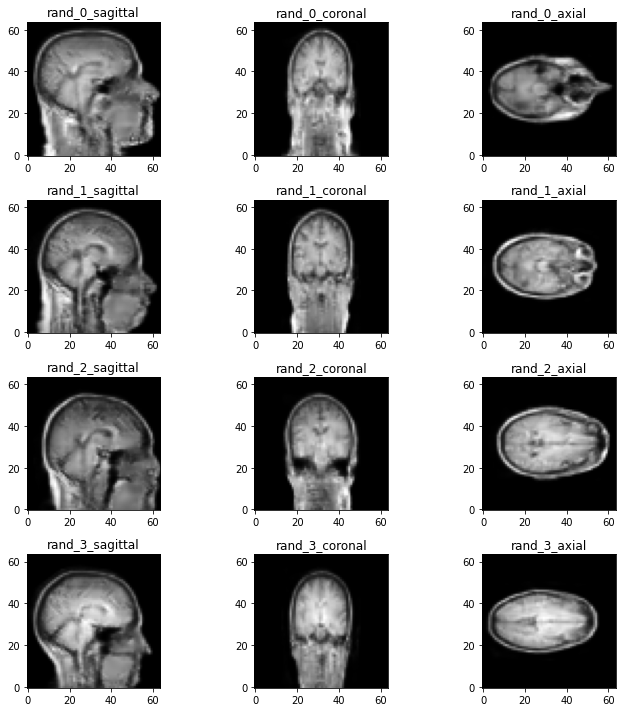

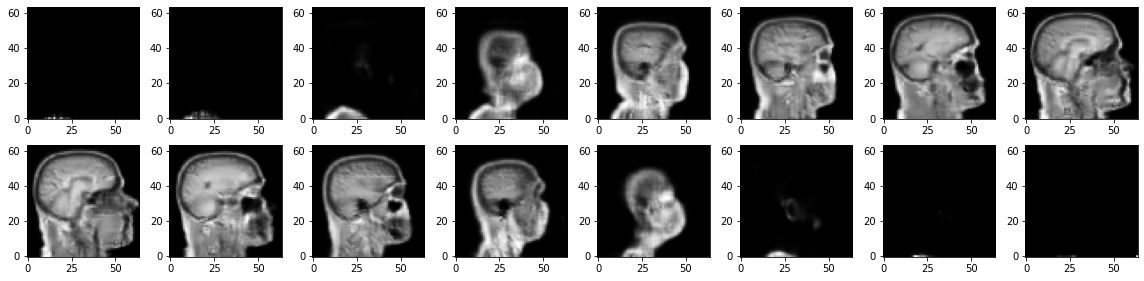

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# 生成器のインスタンス化
G = Generator().to(device)
# 重みを読み込み
path = "saved_mdl/" + str(8000).zfill(5) + "_G.pth"
G.load_state_dict(torch.load(path))
b_size = 4

# ノイズからデータ生成
with torch.no_grad():
    z_rand = torch.randn((b_size, latent_dim)).to(device)
    x_rand = G(z_rand)

# 生成データを描画
axes = ["_sagittal", "_coronal", "_axial"]
methods = [
    lambda x: np.flipud(x[:, :, cube_len // 2]).T, 
    lambda x: x[cube_len // 2],
    lambda x: np.flipud(x[:, cube_len // 2]).T
]

xs = x_rand.data.to('cpu').numpy().copy() * 0.5 + 0.5
plt.figure(figsize=(10, 10))
# 行方向にバッチ内の生成データ4件、列方向に3断面で合計12枚
gs = gridspec.GridSpec(nrows=b_size, ncols=3)

for r in range(b_size):
    x = xs[r][0]
    for c in range(3):
        title = "rand_" + str(r) + axes[c]
        voxel = methods[c](x)
        plt.subplot(gs[r, c])
        plt.title(title)
        plt.imshow(voxel, cmap="gray", origin='lower')
plt.tight_layout()
plt.savefig('triple.png')

# スライスを描画
x = xs[0][0]
# 生成データを矢状断面で16分割する
num_slices = 16
plt.figure(figsize=(16, 4))
# 2行8列で合計16枚
gs = gridspec.GridSpec(nrows=2, ncols=num_slices // 2)
indices = np.linspace(10, x.shape[2] - 10, num_slices)

for i, target in enumerate(indices):
    target = int(target)
    x_slice = np.flipud(x[:, :, target]).T
    plt.subplot(gs[i // (num_slices // 2), i % (num_slices // 2)])
    plt.imshow(x_slice, cmap="gray", origin='lower')

plt.tight_layout()
plt.savefig('slices.png')
